In [1]:
from typing import Optional

import warnings
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
from statsmodels.stats.multitest import multipletests
from matplotlib import pyplot as plt

pd.set_option('display.max_rows', 500)

import genpred
from genpred.utils.sequences import load_genes_list


In [2]:
def fetch_data_paths(
    dataset: str,
    vectorizer: str = "sentencepiece",
    vocab_size: Optional[int] = None,
):
    """Fetch dataset paths."""
    root = genpred.EXPS_ROOT / "knockout" / dataset / vectorizer / f"{vocab_size}"
    return sorted(root.glob("*NEIS*/predictions.csv"))


# Gene knockout analysis

## 1. Methods

In this notebook, we are going to see the effect of removing the genes loci from genomes classified as invasive high confidence. The algorithm to knock-out a gene is the following:

- First, we identify whether the genome contains the gene locus. If not, the process is interrupted.
- If there is a locus, we replace the bases at the locus location with `X`s.
- We encode the genome with the knocked-out gene using the best Sentencepiece model as found with model selection (vocab. size `32000`) and predict it accordingly.
- We use these data to compare the prediction with and without the knockout to spot meaningful differences.

We repeat this process for a set of all loci annotated in PubMLST for the `disease` dataset  (`2808`), and for each genome where the classifier predicts invasiveness with high confidence (`>=0.99`, for a total of `436` genomes). 


<!-- In this analysis, we are going to see if there is significative overlap between the genes which the classifier "thinks" are significant, and two lists of genes with known associations to invasiveness taken from the literature:
- the panel of genes in Siena et al., consisting of 172 virulence factors, from which we selected a subset of 155 with known NEIS loci
- the panel of genes in Earle at al., consisting of 17 genes, from which we selected a subset of 15 having known NEIS loci.

Below, we load the entire set of genes, and the two panels: -->

In [3]:
all_genes = load_genes_list("all_genes.txt")
print("Number of Neisseria meningitidis genes:", len(all_genes))

Number of Neisseria meningitidis genes: 2808


## 2. Results

### 2.1 Model predictions change significantly (wrt control) once VF loci are knocked out

Here, we show that the model predictions positively correlate with biological expectations. Specifically, we will knock out from the high-confidence invasive genomes a set of known virulence factors (Siena et al.). The list consists of `172` genes, from which we extracted a subset of `155` annotated in PubMLST.

In [4]:
virulence_factors = load_genes_list("virulence_factors.txt")
print("Number of genes taken from Siena et al.:", len(virulence_factors))

Number of genes taken from Siena et al.: 155


We load the predictions of the genomes where the VFs panel was knocked-out (`knockout` group), and the predictions of the same genomes where random locations where knocked out instead (`control` group). We print the mean number of bases removed to verify that it is the same for the two groups.

In [5]:
vf_control_data = pd.read_csv(genpred.EXPS_ROOT / "knockout/disease/sentencepiece/32000/virulence-control/predictions.csv").rename({"Original": "Before", "Removed": "After"}, axis=1)
print("Number of genomes:", len(vf_control_data))
print(f"Mean length of bases removed (control group) {vf_control_data.Length.mean()} +/- {vf_control_data.Length.std()}")
print(f"Mean prediction delta before knockout (control group): {vf_control_data.Before.mean()} +/- {vf_control_data.Before.std()}")
print(f"Number of invasive genomes before knockout (control group): {(vf_control_data.Before>0.5).sum()}")
print(f"Mean prediction delta after knockout (control group): {vf_control_data.After.mean()} +/- {vf_control_data.After.std()}")
print(f"Number of invasive genomes after knockout (control group): {(vf_control_data.After>0.5).sum()}")
print(f"Number of switches from invasive to carriage after knockout (control group): {len(vf_control_data) - (vf_control_data.After>0.5).sum()}")

Number of genomes: 436
Mean length of bases removed (control group) 152202.67431192662 +/- 9981.1830954871
Mean prediction delta before knockout (control group): 0.9995681657332073 +/- 0.0014104877175653268
Number of invasive genomes before knockout (control group): 436
Mean prediction delta after knockout (control group): 0.9688235488948956 +/- 0.12942125407001173
Number of invasive genomes after knockout (control group): 423
Number of switches from invasive to carriage after knockout (control group): 13


In [6]:
vf_ko_data = pd.read_csv(genpred.EXPS_ROOT / "knockout/disease/sentencepiece/32000/virulence/predictions.csv").rename({"Original": "Before", "Removed": "After"}, axis=1)
print("Number of genomes:", len(vf_ko_data))
print(f"Mean length of bases removed (knockout group) {vf_control_data.Length.mean()} +/- {vf_control_data.Length.std()}")
print(f"Mean prediction delta before knockout (knockout group): {vf_ko_data.Before.mean()} +/- {vf_ko_data.Before.std()}")
print(f"Number of invasive genomes before knockout (knockout group): {(vf_ko_data.Before>0.5).sum()}")
print(f"Mean prediction delta after knockout (knockout group): {vf_ko_data.After.mean()} +/- {vf_ko_data.After.std()}")
print(f"Number of invasive genomes after knockout (knockout group): {(vf_ko_data.After>0.5).sum()}")
print(f"Number of switches from invasive to carriage after knockout (control group): {len(vf_ko_data) - (vf_ko_data.After>0.5).sum()}")

Number of genomes: 436
Mean length of bases removed (knockout group) 152202.67431192662 +/- 9981.1830954871
Mean prediction delta before knockout (knockout group): 0.9995681657332073 +/- 0.0014104877175653268
Number of invasive genomes before knockout (knockout group): 436
Mean prediction delta after knockout (knockout group): 0.46823156116662185 +/- 0.41576500078178136
Number of invasive genomes after knockout (knockout group): 206
Number of switches from invasive to carriage after knockout (control group): 230


Like we did for the capsule, we know plot the prediction deltas for each group to visualize the effect of the knockout.

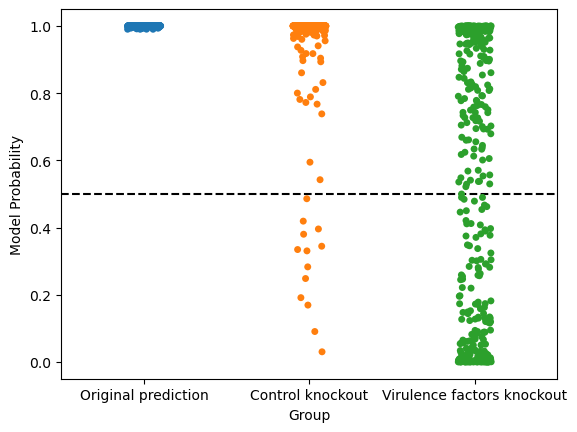

In [7]:
data = pd.DataFrame({"Genome": vf_control_data.Genome, "Original prediction": vf_control_data.Before, "Control knockout": vf_control_data.After, "Virulence factors knockout": vf_ko_data.After})
ax = sns.stripplot(data=data)
ax.axhline(y=0.5, color="k", linestyle="--")
ax.set_ylabel("Model Probability")
ax.set_xlabel("Group");

data.to_csv("fig5_panelB.csv", index=False)

Similarly as what we did for the capsule task, we show that the deltas observed in the knock-out group are significantly different than the deltas observed in the control group. To do so, we use a Wilcoxon signed rank test (null hypothesis: **no difference between the deltas in the control group and the deltas in the knockout group**). We reject the null hypothesis at a significance level $\alpha = 0.05$:

In [8]:
SIGNIFICANCE_LEVEL = 0.05

pvalue = stats.wilcoxon(data["Control knockout"], data["Virulence factors knockout"], method="approx", correction=True).pvalue

if pvalue < SIGNIFICANCE_LEVEL:
    print(f"Null hypothesis rejected (p-value {pvalue})")
else:
    print(f"Not enough evidence to reject the null hypothesis (p-value {pvalue})")

Null hypothesis rejected (p-value 7.120937814906213e-72)


### 2.2 Relevant gene analysis shows significant overlap with VF list

Here, we use the knockouts on the classifier predictions to find a set of genes potentially relevant for invasiveness. We start by assembling the prediction deltas in a `436 x 2808` matrix where rows are the genomes and loci are the columns. Position $(i,j)$ of the matrix contains the prediction delta obtained by knocking out locus $j$ in genome $i$.

In [9]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    columns = {}

    for path in fetch_data_paths("disease", "sentencepiece", 32000):
        locus = path.parts[-2]
        predictions = pd.read_csv(path).set_index("Genome").rename({"Original": "Before", "Removed": "After"}, axis=1)
        delta = predictions.Before - predictions.After
        columns[locus] = delta.where(delta >= 0, 0).values
        
data = pd.DataFrame(columns, index=predictions.index)  # type: ignore
data.head()


,NEIS0001,NEIS0004,NEIS0005,NEIS0006,NEIS0007,NEIS0008,NEIS0009,NEIS0010,NEIS0011,NEIS0012,...,NEIS3168,NEIS3169,NEIS3170,NEIS3171,NEIS3172,NEIS3173,igr_up_NEIS0055,igr_up_NEIS0349,igr_up_NEIS0350,igr_up_NEIS0351
Genome,,,,,,,,,,,,,,,,,,,,,
42543_M16-240086_,1.469459e-08,8.203836e-09,9.650859e-08,4.575681e-08,3.003825e-06,0.0,8.025416e-07,3.349459e-08,0.000000e+00,1.447445e-07,...,0.0,0.0,2.079558e-08,9.657283e-09,0.000000e+00,0.0,0.000000e+00,0.0,4.767897e-09,4.767897e-09
89107_64-2014_,0.000000e+00,3.096673e-09,2.381490e-08,1.591732e-07,1.921041e-07,0.0,7.226120e-07,0.000000e+00,4.619114e-08,0.000000e+00,...,0.0,0.0,0.000000e+00,0.000000e+00,2.012204e-09,0.0,0.000000e+00,0.0,0.000000e+00,0.000000e+00
89108_65-2014_,2.150753e-07,4.204363e-07,1.628949e-07,9.036685e-07,5.150906e-09,0.0,1.080198e-07,0.000000e+00,0.000000e+00,1.962997e-07,...,0.0,0.0,0.000000e+00,0.000000e+00,4.032451e-07,0.0,4.634307e-08,0.0,0.000000e+00,0.000000e+00
94468_M19-240201_,1.053874e-08,8.960740e-09,0.000000e+00,5.517361e-08,5.452092e-08,0.0,8.286444e-09,1.624428e-08,4.256804e-09,4.252095e-08,...,0.0,0.0,8.857652e-10,2.348969e-08,6.589978e-09,0.0,5.107651e-09,0.0,0.000000e+00,0.000000e+00
59656_2180249_I_,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.0,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.0,0.000000e+00,0.000000e+00


From this matrix, we obtain a set of `306` relevant loci. We consider a locus relevant if: 
- for each genome, its delta is above the 95th percentile of the other prediction deltas in the same genome;
- the former happens in at least 50 genomes.

In [10]:
filtered_data = data.apply(lambda x: x>x.quantile(0.95), axis=1)
impact_genome_wise = filtered_data.sum().sort_values(ascending=False)
relevant_loci = impact_genome_wise[impact_genome_wise >= 50]
relevant_loci = pd.DataFrame({"locus": relevant_loci.index, "ranking": relevant_loci.values})
print(f"Number of relevant loci: {len(relevant_loci.locus)}")

Number of relevant loci: 306


We check whether there is a significant overlap between this list and the set of virulence factors in Siena et al. To establish whether there is a significant overlap between the relevant genes and the two panel lists, we use a Fisher exact test. Specifically, we construct a contingency matrix $[[a, b],[c, b]]$ where:

- $a$ is the number of genes shared between the panel set and the set of significant genes
- $b$ is the number of genes in the panel set (not shared)
- $c$ is the number of genes in the significant gene set (not shared)
- $d$ is the number of genes from the set of all genes (not shared)

We apply the Fisher exact test to the contingency table. Results are summarized below.

In [11]:
def compute_overlap_significance(setA, setB, M):
    setA, setB = set(setA), set(setB)
    
    n, N = len(setA), len(setB)
    x = len(setA.intersection(setB))

    a = x                 # how many shared 
    b = n - x             # how many in B excluding shared
    c = N - x             # how many in A excluding shared
    d = M - (n + N) + x   # how many in total excluding A and B

    # print('p-value <= ' + str(x) + ': ' + str(stats.hypergeom.cdf(x, M, n, N)))
    # print('p-value >= ' + str(x)  + ': ' + str(stats.hypergeom.sf(x-1, M, n, N)))

    contingency_table = np.array([[a, b], [c, d]])
    return stats.fisher_exact(contingency_table)[1]

pvalue_vf = compute_overlap_significance(virulence_factors, relevant_loci.locus, M=len(all_genes))

rows = []
intersection_vf = set(virulence_factors).intersection(set(relevant_loci.locus))
length_intersection_vf = len(intersection_vf)

rows.append({
    "Study": "Siena et al.",
    "Total number of loci": len(all_genes),
    "Number of significant loci": len(relevant_loci.locus),
    "Number of loci in VF panel": len(virulence_factors),
    "Number of overlapping loci": length_intersection_vf,
    "Overlap p-value": pvalue_vf,
    "Overlapping": ', '.join(sorted(intersection_vf))  # type: ignore
})

results = pd.DataFrame(rows)
results

,Study,Total number of loci,Number of significant loci,Number of loci in VF panel,Number of overlapping loci,Overlap p-value,Overlapping
0,Siena et al.,2808,306,155,44,4.151461e-10,"NEIS0020, NEIS0049, NEIS0052, NEIS0053, NEIS00..."


### 2.3 Relevant gene enrichment with DAVID and top 10 genes according to proposed ranking

We now retrieve the gene names for the loci and run an enrichment analysis with DAVID on the set of relevant genes. Some genes are not annotated on PubMLST, restricting the set to `291` genomes. We show the top 10 genomes according to the ranking (the full list is available in the `relevant_genes.csv` file).

In [14]:
nmb_data = pd.merge(relevant_loci, pd.read_csv("../data/genes/neis_nmb.txt"), on="locus")

# with open("nmb.txt", "w") as f:
#     print("\n".join(nmb_data.NMB_locus), file=f)

nmb_gene_data = pd.merge(nmb_data, pd.read_csv("../data/genes/nmb_gene_data.txt", sep="\t"), on="NMB_locus")
nmb_gene_data.to_csv("relevant_genes.csv", index=False)

# Top 10
nmb_gene_data[["locus", "NMB_locus", "gene", "Name", "product", "NCBI"]][:10].fillna("-")



,locus,NMB_locus,gene,Name,product,NCBI
0,NEIS0054,NMB0070,synX,synX,polysialic acid capsule biosynthesis protein SynX,http://www.ncbi.nlm.nih.gov/gene/?term=NMB0070
1,NEIS0053,NMB0069,siaB,siaB,polysialic acid capsule biosynthesis protein SiaB,http://www.ncbi.nlm.nih.gov/gene/?term=NMB0069
2,NEIS1464,NMB1536,secA,secA,preprotein translocase subunit SecA,http://www.ncbi.nlm.nih.gov/gene/?term=NMB1536
3,NEIS0044,NMB0060,-,NMB0060,hypothetical protein,http://www.ncbi.nlm.nih.gov/gene/?term=NMB0060
4,NEIS1191,NMB1024,-,NMB1024,hypothetical protein,http://www.ncbi.nlm.nih.gov/gene/?term=NMB1024
5,NEIS2113,NMB2135,-,NMB2135,hypothetical protein,http://www.ncbi.nlm.nih.gov/gene/?term=NMB2135
6,NEIS1468,NMB1540,lbpA,lbpA,lactoferrin-binding protein A,http://www.ncbi.nlm.nih.gov/gene/?term=NMB1540
7,NEIS0418,NMB1803,-,NMB1803,cytochrome c-type biogenesis protein,http://www.ncbi.nlm.nih.gov/gene/?term=NMB1803
8,NEIS0052,NMB0068,siaC,siaC,polysialic acid capsule biosynthesis protein SiaC,http://www.ncbi.nlm.nih.gov/gene/?term=NMB0068
9,NEIS1645,NMB1725,fixN,fixN,cbb3-type cytochrome c oxidase subunit I,http://www.ncbi.nlm.nih.gov/gene/?term=NMB1725


We run DAVID on the full list of relevant genes to annotate functional clusters. Results are available in the `results_david.txt` file.